## Word Embedding 

- Word embedding is one of the most popular representation of document vocabulary.
- It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.
- They are vector representations of a particular word.

## Word2Vec 

- Word2Vec is a method to construct such an embedding. 
- It can be obtained using two methods (both involving Neural Networks): Skip Gram and Common Bag Of Words (CBOW)


## CBOW Model: 

- This method takes the context of each word as the input and tries to predict the word corresponding to the context.
- Consider our example: Have a great day.
- Let the input to the Neural Network be the word, "great". 
- Notice that here we are trying to predict a target word (day) using a single context input word great.
- More specifically, we use the one hot encoding of the input word and measure the output error compared to one hot encoding of the target word (day).
- In the process of predicting the target word, we learn the vector representation of the target word.

In [1]:
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
import re 
import numpy as np
from scipy import linalg
from collections import defaultdict

In [2]:
#nltk.download('punkt')

In [3]:
# Download sentence tokenizer
nltk.data.path.append('.')

Let's dive into the neural network itself, which is shown below with all the dimensions and formulas you'll need.

<div style="width:image width px; font-size:100%; text-align:center;"><img src='./cbow_model_dimensions_single_input.png?2' alt="alternate text" width="width" height="height" style="width:839;height:349;" /> Figure 2 </div>

## Reading Data

In [4]:
def read_data():
    with open('./shakespeare.txt') as f:
        data = f.read() 
    return data

## Preprocessing The Data

In [5]:
def preprocess(data):
    data = re.sub(r'[,!?;-]', '.',data)                                
    data = nltk.word_tokenize(data)                                     
    data = [ ch.lower() for ch in data if ch.isalpha() or ch == '.']
    return data

In [6]:
def get_dict(data):
    words = sorted(list(set(data)))
    n = len(words)
    idx = 0
    # return these correctly
    word2Ind = {}
    Ind2word = {}
    for k in words:
        word2Ind[k] = idx
        Ind2word[idx] = k
        idx += 1
    return word2Ind, Ind2word

## Making Batches

In [7]:
def get_idx(words, word2Ind):
    idx = []
    for word in words:
        idx = idx + [word2Ind[word]]
    return idx

In [8]:
def pack_idx_with_frequency(context_words, word2Ind):
    freq_dict = defaultdict(int)
    for word in context_words:
        freq_dict[word] += 1
    idxs = get_idx(context_words, word2Ind)
    packed = []
    for i in range(len(idxs)):
        idx = idxs[i]
        freq = freq_dict[context_words[i]]
        packed.append((idx, freq))
    return packed

In [9]:
def get_vectors(data, word2Ind, V, C):
    i = C
    while True:
        y = np.zeros(V)
        x = np.zeros(V)
        center_word = data[i]
        y[word2Ind[center_word]] = 1
        context_words = data[(i - C) : i] + data[(i + 1) : (i + C + 1)]
        num_ctx_words = len(context_words)
        for idx, freq in pack_idx_with_frequency(context_words, word2Ind):
            x[idx] = freq / num_ctx_words
        yield x, y
        i += 1
        if i >= len(data):
            print("i is being set to 0")
            i = 0

In [10]:
def get_batches(data, word2Ind, V, C, batch_size):
    batch_x = []
    batch_y = []
    for x, y in get_vectors(data, word2Ind, V, C):
        while len(batch_x) < batch_size:
            batch_x.append(x)
            batch_y.append(y)
        else:
            yield np.array(batch_x).T, np.array(batch_y).T
            batch_x = []
            batch_y = []

## Activation Functions

### Softmax Function
This function is used to calculate the values of the output layer of the neural network, using the following formulas:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \tag{3} \\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \tag{4} \\
\end{align}

To calculate softmax of a vector $\mathbf{z}$, the $i$-th component of the resulting vector is given by:

$$ \textrm{softmax}(\textbf{z})_i = \frac{e^{z_i} }{\sum\limits_{j=1}^{V} e^{z_j} }  \tag{5} $$


In [11]:
def softmax(z):
    # Calculate yhat (softmax)
    e_z = np.exp(z)
    yhat = e_z/np.sum(e_z,axis=0)
    return yhat

## Intialize the Weights

In [12]:
def initialize_model(N,V, random_seed=1):
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    # W2 has shape (V,N)
    W2 = np.random.rand(V,N)
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    return W1, W2, b1, b2

## Compute Cost

The formula for cross-entropy loss is:

$$ J=-\sum\limits_{k=1}^{V}y_k\log{\hat{y}_k} \tag{6}$$


In [13]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

## Forward Prop

### Values of the hidden layer

As we have initialized all the variables that we need for forward propagation, we can calculate the values of the hidden layer using the following formulas:

\begin{align}
 \mathbf{z_1} = \mathbf{W_1}\mathbf{x} + \mathbf{b_1}  \tag{1} \\
 \mathbf{h} = \mathrm{ReLU}(\mathbf{z_1})  \tag{2} \\
\end{align}


### Values of the output layer

Here are the formulas, Need to calculate the values of the output layer, represented by the vector $\mathbf{\hat y}$:

\begin{align}
 \mathbf{z_2} &= \mathbf{W_2}\mathbf{h} + \mathbf{b_2}   \tag{3} \\
 \mathbf{\hat y} &= \mathrm{softmax}(\mathbf{z_2})   \tag{4} \\
\end{align}


In [14]:
def forward_prop(x, W1, W2, b1, b2):
    # Calculate h
    h = np.dot(W1,x)+b1
    # Apply the relu on h (store result in h)
    h = np.maximum(0,h)
    # Calculate z
    z = np.dot(W2,h)+b2
    return z, h

## Backpropagation

The formulas that you will implement for backpropagation are the following.

\begin{align}
 \frac{\partial J}{\partial \mathbf{W_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right )\mathbf{x}^\top \tag{7}\\
 \frac{\partial J}{\partial \mathbf{W_2}} &= (\mathbf{\hat{y}} - \mathbf{y})\mathbf{h^\top} \tag{8}\\
 \frac{\partial J}{\partial \mathbf{b_1}} &= \rm{ReLU}\left ( \mathbf{W_2^\top} (\mathbf{\hat{y}} - \mathbf{y})\right ) \tag{9}\\
 \frac{\partial J}{\partial \mathbf{b_2}} &= \mathbf{\hat{y}} - \mathbf{y} \tag{10}
\end{align}


In [15]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    # Compute l1 as W2^T (Yhat - Y)
    # Re-use it whenever you see W2^T (Yhat - Y) used to compute a gradient
    l1 = np.dot(W2.T,(yhat-y))
    # Apply relu to l1
    l1 = np.maximum(0,l1)
    # Compute the gradient of W1
    grad_W1 = (1/batch_size)*np.dot(l1,x.T) 
    # Compute the gradient of W2
    grad_W2 = (1/batch_size)*np.dot(yhat-y,h.T)
    # Compute the gradient of b1
    grad_b1 = (1.0 / (batch_size)) * np.sum(l1, axis=1, keepdims=True) 
    # Compute the gradient of b2
    grad_b2 = (1.0 / (batch_size)) * np.sum(yhat - y, axis=1, keepdims=True) 
    ### END CODE HERE ###
    
    return grad_W1, grad_W2, grad_b1, grad_b2

## Gradient descent

During the gradient descent phase, you will update the weights and biases by subtracting $\alpha$ times the gradient from the original matrices and vectors, using the following formulas.

\begin{align}
 \mathbf{W_1} &:= \mathbf{W_1} - \alpha \frac{\partial J}{\partial \mathbf{W_1}} \tag{11}\\
 \mathbf{W_2} &:= \mathbf{W_2} - \alpha \frac{\partial J}{\partial \mathbf{W_2}} \tag{12}\\
 \mathbf{b_1} &:= \mathbf{b_1} - \alpha \frac{\partial J}{\partial \mathbf{b_1}} \tag{13}\\
 \mathbf{b_2} &:= \mathbf{b_2} - \alpha \frac{\partial J}{\partial \mathbf{b_2}} \tag{14}\\
\end{align}

First, let set a value for $\alpha$.

In [19]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03,random_seed=282):
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=282)
    batch_size = 128
    iters = 0
    C = 2
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # Get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
        # Get yhat
        yhat = softmax(z)
        # Get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
        # Get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # Update weights and biases
        W1 = W1 - alpha * grad_W1 
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2
        
        iters += 1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [20]:
data = read_data()
data = preprocess(data)
word2Ind, Ind2word = get_dict(data)

In [21]:
C = 2
N = 50
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 150
print("Call gradient_descent")

Call gradient_descent


In [22]:
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

iters: 10 cost: 11.714748
iters: 20 cost: 3.788280
iters: 30 cost: 9.179923
iters: 40 cost: 1.747809
iters: 50 cost: 8.706968
iters: 60 cost: 10.182652
iters: 70 cost: 7.258762
iters: 80 cost: 10.214489
iters: 90 cost: 9.311061
iters: 100 cost: 10.103939
iters: 110 cost: 5.582018
iters: 120 cost: 4.330974
iters: 130 cost: 9.436612
iters: 140 cost: 6.875775
iters: 150 cost: 2.874090


## Compute PCA

In [23]:
def compute_pca(data, n_components=2):
    m, n = data.shape

    # mean center the data
    data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = linalg.eigh(R)
    # sort eigenvalue in decreasing order
    # this returns the corresponding indices of evals and evecs
    idx = np.argsort(evals)[::-1]

    evecs = evecs[:, idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :n_components]
    
    return np.dot(evecs.T, data.T).T

In [24]:
# visualizing the word vectors here
from matplotlib import pyplot
%config InlineBackend.figure_format = 'svg'
words = ['king', 'queen','lord','man', 'woman','dog','wolf','male',
         'rich','happy','sad']

embs = (W1.T + W2)/2.0
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(11, 50) [2745, 3951, 2961, 3023, 5675, 1452, 5674, 3020, 4191, 2316, 4278]


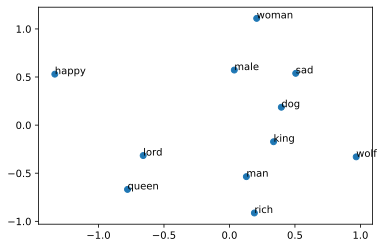

In [25]:
result= compute_pca(X, 2)
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

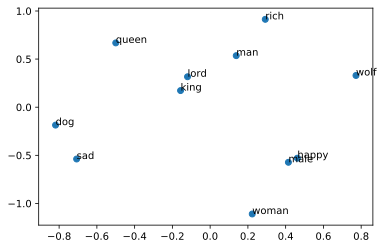

In [26]:
result= compute_pca(X, 4)
pyplot.scatter(result[:, 3], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 3], result[i, 1]))
pyplot.show()

References :
- https://www.coursera.org/learn/probabilistic-models-in-nlp
- https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa